#***Multimedia Data Classification with Feature Visualization***




---


#Dataset: **Birds Species Data**

---

#***1. Dataset Selection - Birds Species Data***

The Bird Species Images Dataset is a valuable resource for classifying and recognizing various bird species, featuring high-quality images with accurate species labels. The dataset includes diverse images reflecting different environments and conditions, making it ideal for computer vision research, species identification, ecological studies, and educational purposes. Sourced from wildlife photographers and field surveys, this dataset supports advancements in image classification algorithms and aids in the conservation of avian biodiversity.

---


#***2. Data preprocessing and cleaning:***

###- Data Source Import and Extraction:

In [ ]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'birds-20-species-image-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3093062%2F5324005%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240527%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240527T083603Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4e414ef3c5c7dc0a2dbee4b7b1d83bb2b7a4079b4db6696c6fc62e8b11df894e403002232813aa961a1618a96012422e2dba4ed66322bbb66ab362b7c8828ade26197da2eda5d3368fee651b10adacaf560b31be3cddc3d5838eb8e790f9dddc24606c46eb36a5a0e088df8247669f5378e6a6d1c1a040a45f018bf3a97d200501015c90faf380f22d16195a8828dd91f03ea79c55dafa6e26da234d8b4398434fc7e3ab8f61c2364717c3325837e5eb0e3938bb84f0708fdbeffb97ded5bf302865e649436932ecf49c34b5de57dc973712124f783ecd5f1cf86538052b6025ce95f6d21076a0ba8274f3d887caf281b862d527b0fac8b8c1a537e5971c3898'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 72669555 bytes downloaded
Downloaded and uncompressed: birds-20-species-image-classification
Data source import complete.


###- Data Path Validation and Images Check:

In [ ]:


# Define the dataset path
dataset_path = os.path.join(KAGGLE_INPUT_PATH, 'birds-20-species-image-classification')

print(f"Dataset path: {dataset_path}")
print(f"Path exists: {os.path.exists(dataset_path)}")

if os.path.exists(dataset_path):
    print("Contents of the dataset directory:")
    for item in os.listdir(dataset_path):
        print(item)
else:
    print("Dataset path does not exist.")

def check_missing_images(dataset_path):
    classes = os.listdir(dataset_path)
    missing_info = []

    for class_name in classes:
        class_path = os.path.join(dataset_path, class_name)
        images = os.listdir(class_path)
        if len(images) == 0:
            missing_info.append(class_name)

    if len(missing_info) > 0:
        print(f"Missing images in the following classes: {missing_info}")
    else:
        print("No missing images found.")

check_missing_images(dataset_path)


Dataset path: /kaggle/input/birds-20-species-image-classification
Path exists: True
Contents of the dataset directory:
images to predict
valid
test
train
No missing images found.




---


#**3. Exploratory Data Analysis (EDA):**

EDA of images involves visually exploring the dataset to understand its characteristics, such as image dimensions, color distributions, and pixel intensities. This analysis helps in gaining insights into the data's structure and properties, guiding preprocessing steps and model selection for image-based tasks.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import seaborn as sns
import os
import random

###- Count the no. of images in each folder

In [ ]:
def count_images_in_subfolders(root_folder):
    class_counts = {}
    for foldername in os.listdir(root_folder):
        folder_path = os.path.join(root_folder, foldername)
        if os.path.isdir(folder_path):
            image_count = len([filename for filename in os.listdir(folder_path) if filename.endswith(('.jpg', '.jpeg', '.png'))])
            class_counts[foldername] = image_count
    return class_counts


### - Print the image distribution in each folder

In [ ]:
def plot_bar_graph(class_counts, name, color):
    labels = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(labels, counts, color=color)
    plt.xlabel('Subfolders')
    plt.ylabel('Number of Images')
    plt.title(f'Number of Images in {name}')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

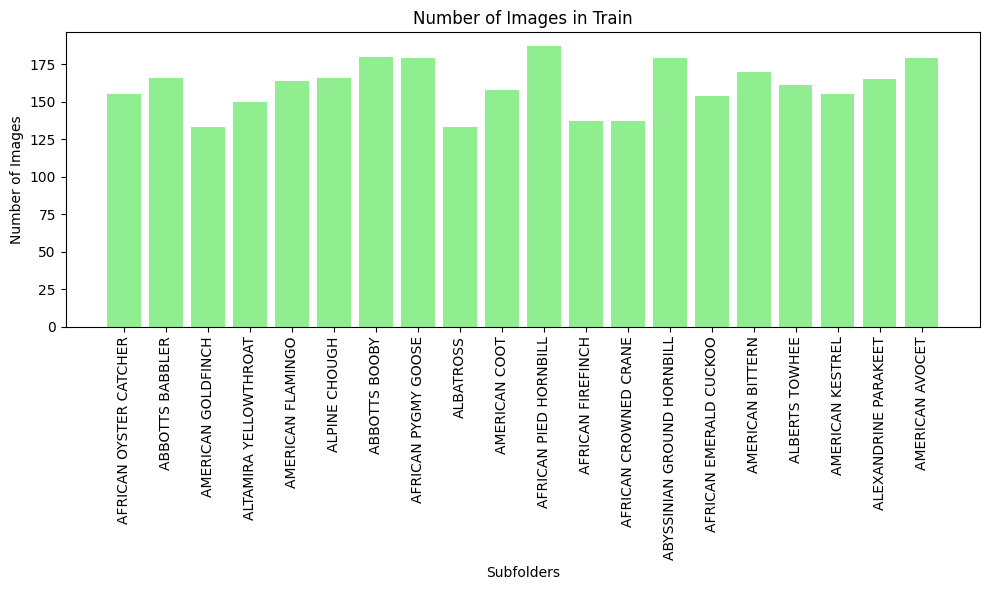

In [ ]:
class_counts = count_images_in_subfolders('/kaggle/input/birds-20-species-image-classification/train')
plot_bar_graph(class_counts, 'Train', 'lightgreen')

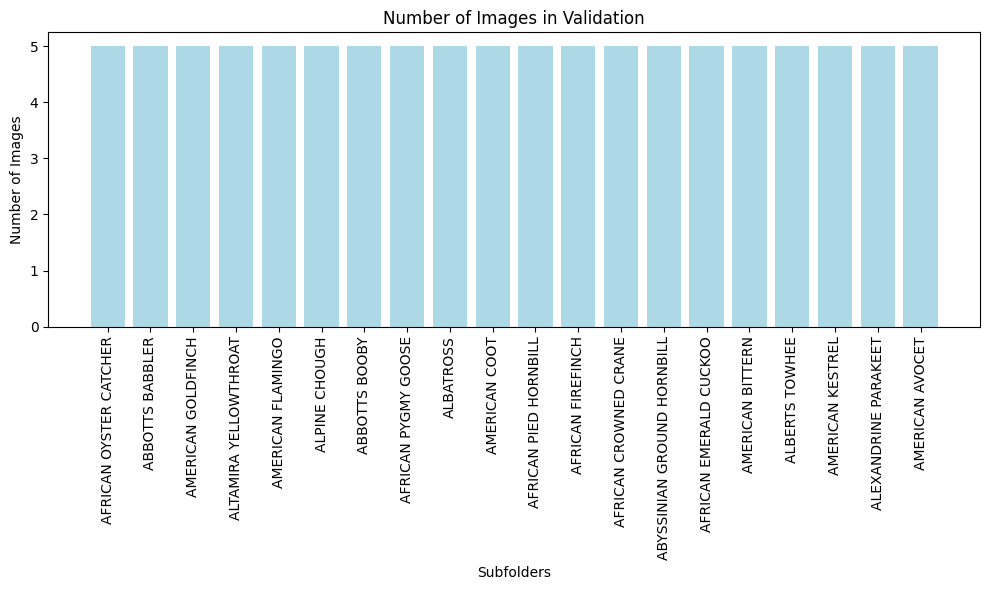

In [ ]:
class_counts = count_images_in_subfolders('/kaggle/input/birds-20-species-image-classification/valid')
plot_bar_graph(class_counts, 'Validation', 'lightblue')

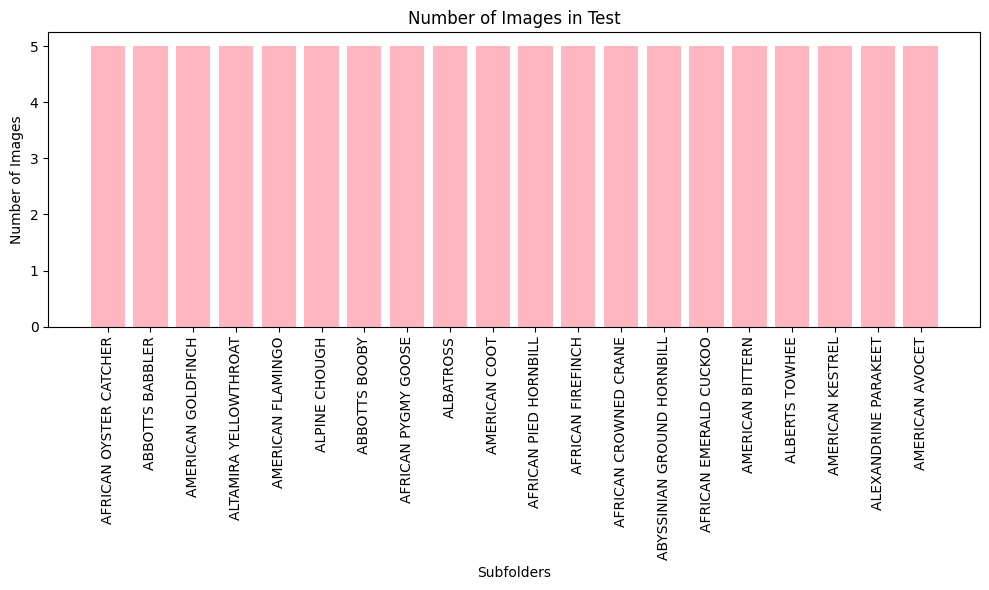

In [ ]:
class_counts = count_images_in_subfolders('/kaggle/input/birds-20-species-image-classification/test')
plot_bar_graph(class_counts, 'Test', 'lightpink')

### - Visualize a few images from the training set

In [ ]:
def visualize_random_images(directory, num_images=5):

    image_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith((".jpg", ".jpeg", ".png")):
                image_files.append(os.path.join(root, file))


    random_images = random.sample(image_files, num_images)


    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i, image_path in enumerate(random_images):
        img = mpimg.imread(image_path)
        subfolder_name = os.path.basename(os.path.dirname(image_path))
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(subfolder_name)
    plt.show()

In [ ]:
image_files = []
for root, dirs, files in os.walk('/kaggle/input/birds-20-species-image-classification/train'):
    for file in files:
        if file.endswith((".jpg", ".jpeg", ".png")):
            image_files.append(os.path.join(root, file))

In [ ]:
img = mpimg.imread(image_files[0])

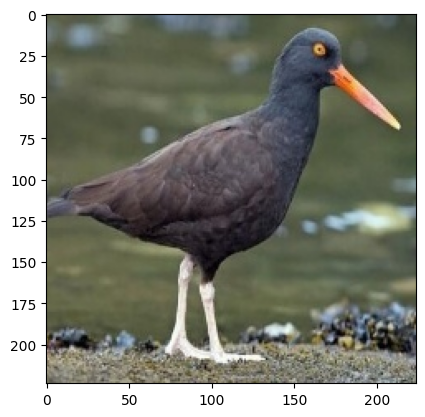

In [ ]:
plt.imshow(img)

### - Contrast, Brightness, and RGB Colors Analysis

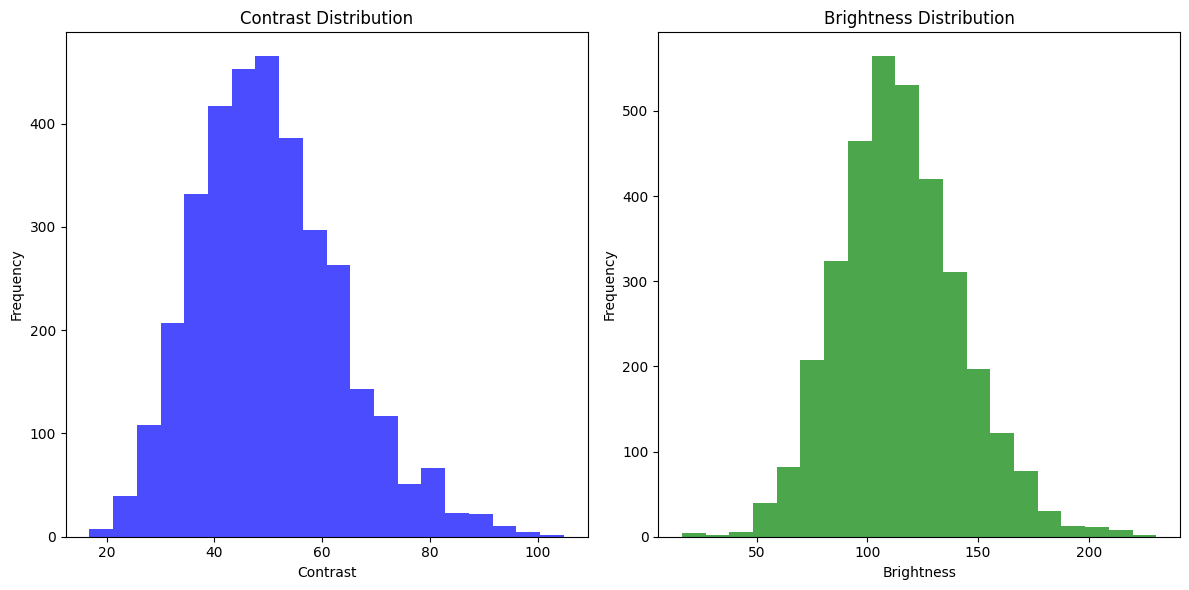

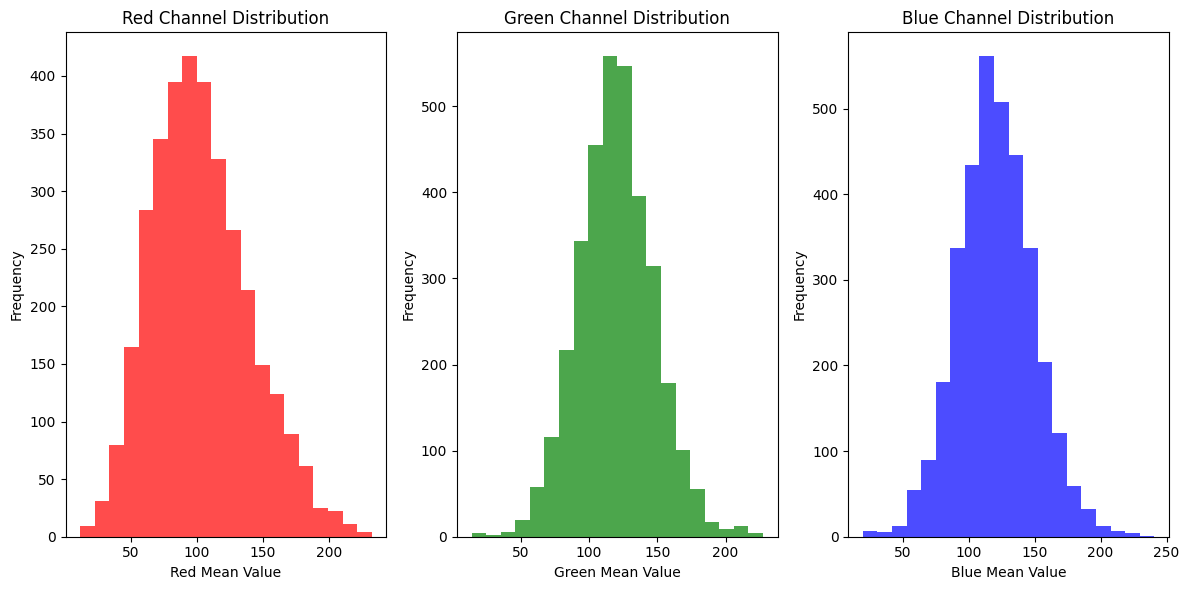

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define the dataset path
dataset_path = '/kaggle/input/birds-20-species-image-classification'

# Function to compute contrast of an image
def compute_contrast(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    contrast = np.std(gray_image)
    return contrast

# Function to compute brightness of an image
def compute_brightness(image):
    brightness = np.mean(image)
    return brightness

# Function to compute RGB colors of an image
def compute_rgb_colors(image):
    r_mean = np.mean(image[:,:,0])
    g_mean = np.mean(image[:,:,1])
    b_mean = np.mean(image[:,:,2])
    return r_mean, g_mean, b_mean

# Lists to store computed values
contrast_values = []
brightness_values = []
rgb_colors = []

# Iterate through images in the dataset directory
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith('.jpg') or file.endswith('.png'):
            # Read the image
            image_path = os.path.join(root, file)
            image = cv2.imread(image_path)

            # Compute contrast
            contrast = compute_contrast(image)
            contrast_values.append(contrast)

            # Compute brightness
            brightness = compute_brightness(image)
            brightness_values.append(brightness)

            # Compute RGB colors
            r_mean, g_mean, b_mean = compute_rgb_colors(image)
            rgb_colors.append((r_mean, g_mean, b_mean))

# Plot histograms for contrast and brightness
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(contrast_values, bins=20, color='blue', alpha=0.7)
plt.title('Contrast Distribution')
plt.xlabel('Contrast')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(brightness_values, bins=20, color='green', alpha=0.7)
plt.title('Brightness Distribution')
plt.xlabel('Brightness')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Plot RGB color distributions
r_values, g_values, b_values = zip(*rgb_colors)
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.hist(r_values, bins=20, color='red', alpha=0.7)
plt.title('Red Channel Distribution')
plt.xlabel('Red Mean Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(g_values, bins=20, color='green', alpha=0.7)
plt.title('Green Channel Distribution')
plt.xlabel('Green Mean Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(b_values, bins=20, color='blue', alpha=0.7)
plt.title('Blue Channel Distribution')
plt.xlabel('Blue Mean Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()




---


#**4. Feature Extraction:**



### - Dimensionality reduction : Principal Component Analysis (PCA)

In [ ]:
import cv2

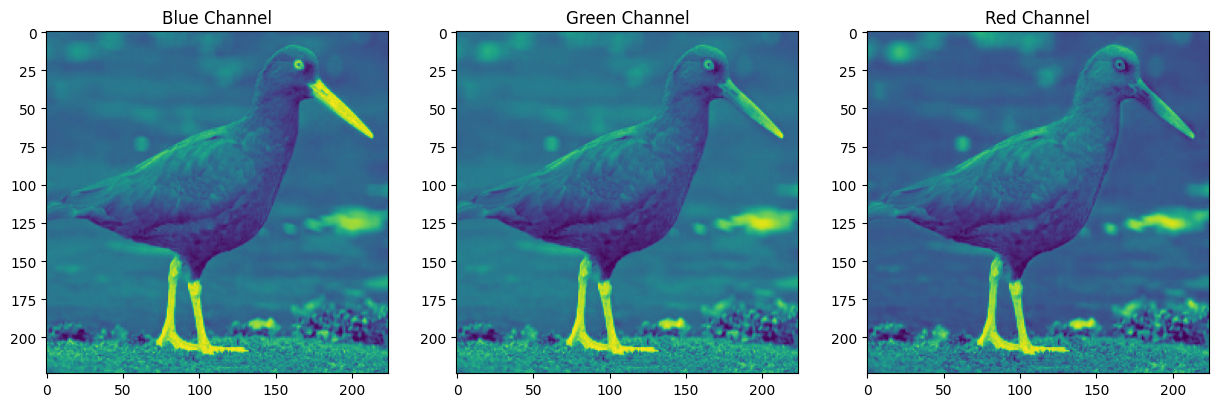

In [ ]:
blue,green,red = cv2.split(img)

fig = plt.figure(figsize = (15, 7.2))
fig.add_subplot(131)

plt.title("Blue Channel")
plt.imshow(blue)

fig.add_subplot(132)
plt.title("Green Channel")
plt.imshow(green)

fig.add_subplot(133)
plt.title("Red Channel")
plt.imshow(red)
plt.show()

In [ ]:
df_blue = blue/255
df_red = red/255
df_green = green/255

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca_b = PCA(n_components=50)



In [ ]:
pca_b.fit(df_blue)
trans_pca_b = pca_b.transform(df_blue)
print(trans_pca_b.shape)

(224, 50)


In [ ]:
pca_r = PCA(n_components=50)
pca_r.fit(df_red)
trans_pca_r = pca_r.transform(df_red)
print(trans_pca_r.shape)

(224, 50)


In [ ]:
pca_g = PCA(n_components=50)
pca_g.fit(df_green)
trans_pca_g = pca_g.transform(df_green)
print(trans_pca_g.shape)

(224, 50)


In [ ]:
print(f"Blue Channel : {sum(pca_b.explained_variance_ratio_)}")
print(f"Blue Channel : {sum(pca_r.explained_variance_ratio_)}")

print(f"Blue Channel : {sum(pca_g.explained_variance_ratio_)}")


Blue Channel : 0.97952962794494
Blue Channel : 0.9781640813121347
Blue Channel : 0.9789367854637565


<BarContainer object of 50 artists>

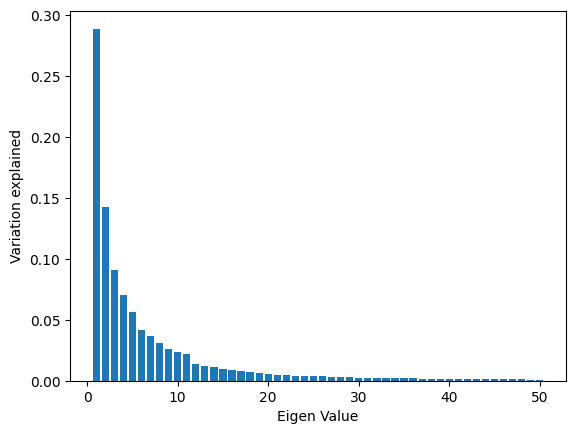

In [ ]:
plt.ylabel('Variation explained')
plt.xlabel('Eigen Value')
plt.bar(list(range(1,51)),pca_b.explained_variance_ratio_)

In [ ]:
b_arr = pca_b.inverse_transform(trans_pca_b)
g_arr = pca_g.inverse_transform(trans_pca_g)

r_arr = pca_r.inverse_transform(trans_pca_r)

print(b_arr.shape)

(224, 224)


In [ ]:
img_reduced= (cv2.merge((r_arr, g_arr, b_arr)))
print(img_reduced.shape)

(224, 224, 3)


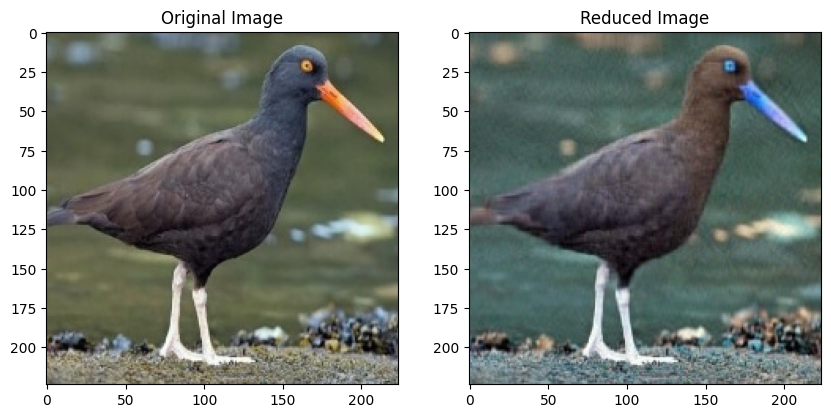

In [ ]:
fig = plt.figure(figsize = (10, 7.2))
fig.add_subplot(121)
plt.title("Original Image")
plt.imshow(img.astype('uint8'))
fig.add_subplot(122)
plt.title("Reduced Image")
plt.imshow(img_reduced)
plt.show()

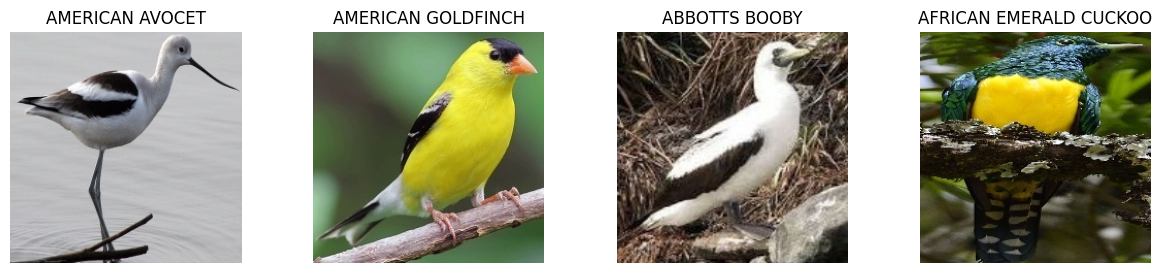

In [ ]:
visualize_random_images('/kaggle/input/birds-20-species-image-classification/train', num_images=4)



---


#**5. Data Modeling:**

We employed a CNN model to analyze a dataset containing images of various bird species.

### - Create data loaders from Training and Validation sets:
#### - Applying augmentation only for the Training set

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SHAPE = (224,224)
BATCH_SIZE = 32

tf.random.set_seed(42)

train_dir = '/kaggle/input/birds-20-species-image-classification/train'
valid_dir =  '/kaggle/input/birds-20-species-image-classification/valid'

train_datagen_augmented = ImageDataGenerator(rescale = 1/255.,
                                   rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True)

valid_datagen = ImageDataGenerator(rescale = 1/255.)

train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                              target_size = IMG_SHAPE,
                                              class_mode='categorical',
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              seed = 42)

valid_data = valid_datagen.flow_from_directory(valid_dir,
                                              target_size = IMG_SHAPE,
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              seed = 42)

Found 3208 images belonging to 20 classes.
Found 100 images belonging to 20 classes.


In [ ]:
len(train_data_augmented), len(valid_data)

(101, 7)

In [ ]:
classes = list(train_data_augmented.class_indices.keys())

In [ ]:
classes

['ABBOTTS BABBLER',
 'ABBOTTS BOOBY',
 'ABYSSINIAN GROUND HORNBILL',
 'AFRICAN CROWNED CRANE',
 'AFRICAN EMERALD CUCKOO',
 'AFRICAN FIREFINCH',
 'AFRICAN OYSTER CATCHER',
 'AFRICAN PIED HORNBILL',
 'AFRICAN PYGMY GOOSE',
 'ALBATROSS',
 'ALBERTS TOWHEE',
 'ALEXANDRINE PARAKEET',
 'ALPINE CHOUGH',
 'ALTAMIRA YELLOWTHROAT',
 'AMERICAN AVOCET',
 'AMERICAN BITTERN',
 'AMERICAN COOT',
 'AMERICAN FLAMINGO',
 'AMERICAN GOLDFINCH',
 'AMERICAN KESTREL']

# **Convolutional Neural Network (CNN):**

CNNs are specialized deep learning algorithms designed for image processing. They automatically learn patterns and relationships within images through layers like convolutional, pooling, and fully connected layers. By extracting features like edges and textures, CNNs excel at tasks like image recognition and classification, making them ideal for analyzing complex datasets like bird images.

In [ ]:
model= tf.keras.Sequential([
    # Convolutional layers
    tf.keras.layers.Conv2D(64, (11, 11), strides=(4, 4), padding='same', activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),
    tf.keras.layers.Conv2D(192, (5, 5), strides=(1, 1), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),
    tf.keras.layers.Conv2D(384, (3, 3), strides=(1, 1), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),

    # Fully connected layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(20, activation='softmax')
])

model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
             optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4),
             metrics = ['accuracy'])


In [ ]:
history = model.fit(train_data_augmented,
         epochs = 30,
         validation_data = valid_data)

Epoch 1/30
101/101 [==============================] - 332s 3s/step - loss: 2.8970 - accuracy: 0.0764 - val_loss: 2.7051 - val_accuracy: 0.1100
Epoch 2/30
101/101 [==============================] - 329s 3s/step - loss: 2.6972 - accuracy: 0.1172 - val_loss: 2.5268 - val_accuracy: 0.1600
Epoch 3/30
101/101 [==============================] - 326s 3s/step - loss: 2.4384 - accuracy: 0.2117 - val_loss: 2.1449 - val_accuracy: 0.2600
Epoch 4/30
101/101 [==============================] - 332s 3s/step - loss: 2.2232 - accuracy: 0.2796 - val_loss: 1.9493 - val_accuracy: 0.3600
Epoch 5/30
101/101 [==============================] - 326s 3s/step - loss: 2.0057 - accuracy: 0.3357 - val_loss: 1.7229 - val_accuracy: 0.5000
Epoch 6/30
101/101 [==============================] - 326s 3s/step - loss: 1.9150 - accuracy: 0.3825 - val_loss: 1.5256 - val_accuracy: 0.5400
Epoch 7/30
101/101 [==============================] - 327s 3s/step - loss: 1.7994 - accuracy: 0.4236 - val_loss: 1.4389 - val_accuracy: 0.5500

<Axes: >

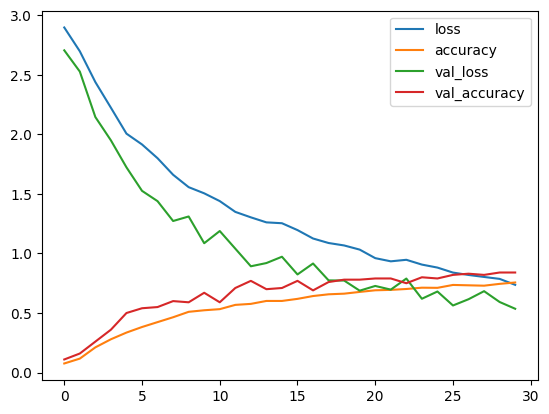

In [ ]:
pd.DataFrame(history.history).plot()



---

#**6. Training and Testing:**

Training is teaching the model using labeled data, while testing checks how well it predicts on new, unseen data.



In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tabulate import tabulate
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


Original number of features: 3072
Reduced number of features: 100
Epoch 1/10
1563/1563 [==============================] - 10s 6ms/step - loss: 1.6320 - accuracy: 0.4330 - val_loss: 1.4440 - val_accuracy: 0.4872
Epoch 2/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.3572 - accuracy: 0.5192 - val_loss: 1.3994 - val_accuracy: 0.5120
Epoch 3/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.2400 - accuracy: 0.5605 - val_loss: 1.3424 - val_accuracy: 0.5227
Epoch 4/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.1377 - accuracy: 0.5969 - val_loss: 1.3586 - val_accuracy: 0.5248
Epoch 5/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.0544 - accuracy: 0.6275 - val_loss: 1.3799 - val_accuracy: 0.5264
Epoch 6/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.9671 - accuracy: 0.6571 - val_loss: 1.4123 - val_accuracy: 0.5325
Epoch 7/10
1563/1563 [==============================] - 10s 6ms/step 

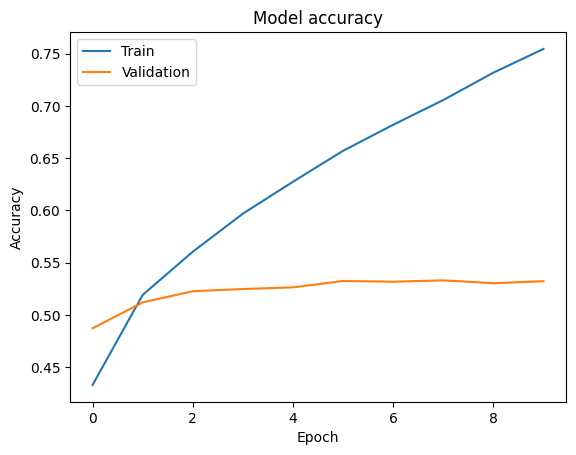

313/313 [==============================] - 1s 2ms/step
[2 8 0 ... 2 4 4]


In [ ]:
# Step 1: Load and Preprocess the CIFAR-10 Image Data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the images to the range [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Flatten the images
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

# Standardize the data
scaler = StandardScaler()
x_train_flat = scaler.fit_transform(x_train_flat)
x_test_flat = scaler.transform(x_test_flat)

# Step 2: Apply PCA
n_components = 100  # Number of principal components
pca = PCA(n_components=n_components)
x_train_pca = pca.fit_transform(x_train_flat)
x_test_pca = pca.transform(x_test_flat)

print(f"Original number of features: {x_train_flat.shape[1]}")
print(f"Reduced number of features: {x_train_pca.shape[1]}")

# Step 3: Train a Neural Network
# Convert labels to categorical one-hot encoding
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

# Build a simple neural network
model = Sequential([
    Dense(512, activation='relu', input_shape=(n_components,)),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train_pca, y_train_cat, epochs=10, batch_size=32, validation_data=(x_test_pca, y_test_cat))

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test_pca, y_test_cat, verbose=2)
print(f"Test accuracy: {test_acc}")

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Apply PCA to test images
test_images_flat = x_test.reshape(x_test.shape[0], -1)  # Flatten images
test_images_pca = pca.transform(test_images_flat)  # Apply PCA

# Make predictions on the test images
test_predictions = model.predict(test_images_pca)

# Convert predictions to class labels (indices)
test_predictions = np.argmax(test_predictions, axis=1)

# Display predictions
print(test_predictions)


### - Analyse the performance of our model in Test directory

In [ ]:
test_data_dir = '/kaggle/input/birds-20-species-image-classification/test'

test_datagen = ImageDataGenerator(rescale=1./255)  # You can add other preprocessing options here if needed

batch_size = 32

test_data = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Assuming you have already defined and compiled the model
test_data.classes


Found 100 images belonging to 20 classes.


array([ 0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,
        3,  3,  3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,
        6,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9, 10,
       10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13,
       13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19],
      dtype=int32)



---
#**7. Results & Findings:**


### - Use the model to predict for the given test images

Found 100 images belonging to 20 classes.
100/100 [==============================] - 5s 53ms/step


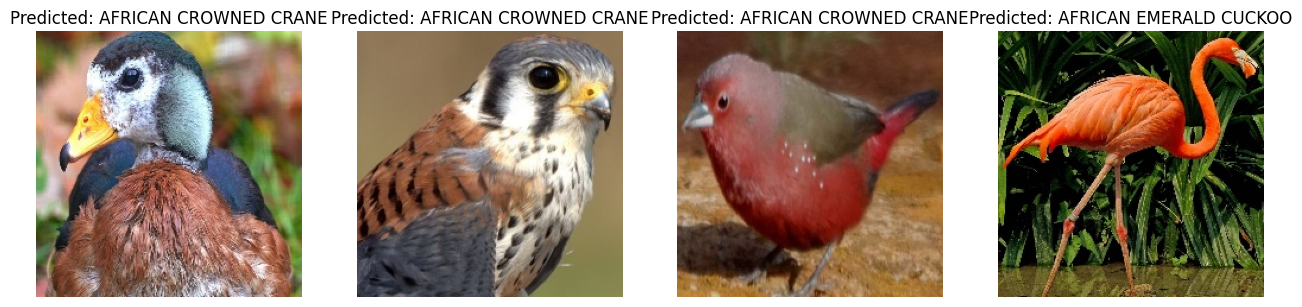

In [ ]:
def predict_images(directory):
    image_paths = [os.path.join(directory, file) for file in os.listdir(directory)]
    num_images = len(image_paths)

    images = []
    predictions = []

    for image_path in image_paths:
        image = tf.io.read_file(image_path)
        image = tf.image.decode_image(image, channels=3)
        image = tf.image.resize(image, (224, 224))
        image = image / 255.0
        images.append(image)

    images = np.array(images)

    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)

    plt.figure(figsize = (20,20))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i])
        plt.title(classes[predicted_classes[i]])
        plt.axis(False)

    plt.show()
def predict_and_visualize_images(image_dir):
    # Load and preprocess the images
    image_generator = ImageDataGenerator(rescale=1./255)
    images = image_generator.flow_from_directory(
        image_dir,
        target_size=(224, 224),
        batch_size=1,
        class_mode=None,  # No labels included
        shuffle=True  # Shuffle the order of images
    )

    # Make predictions
    predictions = model.predict(images)

    # Get the predicted classes
    predicted_classes = np.argmax(predictions, axis=1)

    # Visualize the images along with their predicted labels
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i][0])  # Display the image
        plt.title(f'Predicted: {class_names[predicted_classes[i]]}')
        plt.axis('off')
        if i == 3:
            break
    plt.show()

# Call the function to predict and visualize shuffled images
predict_and_visualize_images('/kaggle/input/birds-20-species-image-classification/test')


In [ ]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 56, 56, 64)        23296     
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 27, 27, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_36 (Conv2D)          (None, 27, 27, 192)       307392    
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 13, 13, 192)       0         
 ng2D)                                                           
                                                                 
 conv2d_37 (Conv2D)          (None, 13, 13, 384)       663936    
                                                                 
 conv2d_38 (Conv2D)          (None, 13, 13, 256)     

#8. Conclusion:



1. **Dataset:** Contains images of 20 different bird species.
2. **Data Preprocessing and Cleaning:** Ensured images are uniform in size, possibly removing noise or artifacts.
3. **Images EDA:** Explored properties of the images, such as distributions of colors or shapes, to gain insights.
4. **Dimensionality Reduction (PCA):** Possibly applied PCA to reduce the dimensionality of image data while retaining important features.
5. **CNN Model:** Implemented a Convolutional Neural Network (CNN) architecture to learn patterns and features from the images.
6. **Training and Testing:** Split the dataset into training and testing sets. Trained the CNN model on the training data and evaluated its performance on the testing data.
7. **Confusion Matrix:** Used to assess the performance of the model by comparing predicted labels with true labels.
8. **Image Prediction:** Finally, the trained model was used to predict the labels of new images based on learned patterns and features.

Overall, the project involved comprehensive steps from data preprocessing to model training and evaluation, with a focus on image classification using a CNN architecture.